In [4]:
pip install pyspark

In [5]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, Imputer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
pip install seaborn

In [7]:
# Buat sesi Spark
spark = SparkSession.builder.appName("DecisionTreeRegressor").getOrCreate()

In [9]:
# Ubah 'file_path' dengan path dataset Anda
file_path = "dataset.csv"
dataset = spark.read.csv(file_path, header=True, inferSchema=True)

In [13]:
# Tampilkan data dari tabel
dataset.show(300)

+-----------------------+---------+---------+
|Provinsi/Kabupaten/Kota|Laki-laki|Perempuan|
+-----------------------+---------+---------+
|                   ACEH|    14025|     8495|
|               SIMEULUE|    11709|     3560|
|               Simeulue|    11709|     3560|
|           ACEH SINGKIL|    15346|     6062|
|           Aceh Singkil|    15346|     6062|
|           ACEH SELATAN|    11317|     7294|
|           Aceh Selatan|    11317|     7294|
|          ACEH TENGGARA|    12210|     8005|
|          Aceh Tenggara|    12210|     8005|
|             ACEH TIMUR|    14215|     5937|
|             Aceh Timur|    14215|     5937|
|            ACEH TENGAH|    11755|     9735|
|            Aceh Tengah|    11755|     9735|
|             ACEH BARAT|    14524|     5852|
|             Aceh Barat|    14524|     5852|
|             ACEH BESAR|    12821|     9205|
|             Aceh Besar|    12821|     9205|
|                  PIDIE|    13249|     9134|
|                  Pidie|    13249

In [ ]:
# Konversi kolom-kolom "Laki-laki" dan "Perempuan" ke tipe data numerik
dataset = dataset.withColumn("Laki-laki", dataset["Laki-laki"].cast("double"))
dataset = dataset.withColumn("Perempuan", dataset["Perempuan"].cast("double"))

In [ ]:
# Menghapus baris yang masih memiliki nilai null
dataset = dataset.dropna()

In [ ]:
# Ganti nilai null dengan nilai rata-rata menggunakan Imputer
imputer = Imputer(inputCols=["Laki-laki", "Perempuan"], outputCols=["Laki-laki_imputed", "Perempuan_imputed"])
dataset = imputer.fit(dataset).transform(dataset)

In [ ]:
# Agregasi data untuk mendapatkan total pengeluaran per kapita
dataset = dataset.withColumn("Total_Pengeluaran", col("Laki-laki_imputed") + col("Perempuan_imputed"))
dataset = dataset.withColumn("Pengeluaran_Per_Kapita", col("Total_Pengeluaran") / (col("Laki-laki_imputed") + col("Perempuan_imputed")))

In [ ]:
# Tentukan kolom fitur yang akan digunakan
feature_columns = ["Laki-laki_imputed", "Perempuan_imputed"]

In [ ]:
# Inisialisasi VectorAssembler untuk menggabungkan fitur-fitur menjadi vektor fitur tunggal
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [ ]:
# Inisialisasi DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(labelCol="Pengeluaran_Per_Kapita", featuresCol="features")

In [ ]:
# Bangun pipeline dengan langkah-langkah yang telah ditentukan
pipeline = Pipeline(stages=[imputer, feature_assembler, dt_regressor])

In [ ]:
# Bagi data menjadi set pelatihan dan set pengujian
(training_data, testing_data) = dataset.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Latih model dengan set pelatihan
model = pipeline.fit(training_data)

In [ ]:
# Buat prediksi dengan set pengujian
predictions = model.transform(testing_data)

In [ ]:
# Evaluasi performa model
evaluator = RegressionEvaluator(labelCol="Pengeluaran_Per_Kapita", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.0


In [ ]:
# Menampilkan schema dataset
dataset.printSchema()

root
 |-- Provinsi/Kabupaten/Kota: string (nullable = true)
 |-- Laki-laki: double (nullable = true)
 |-- Perempuan: double (nullable = true)
 |-- Laki-laki_imputed: double (nullable = true)
 |-- Perempuan_imputed: double (nullable = true)
 |-- Total_Pengeluaran: double (nullable = true)
 |-- Pengeluaran_Per_Kapita: double (nullable = true)



In [ ]:
# Menampilkan statistik deskriptif
dataset.describe().show()

+-------+-----------------------+------------------+-----------------+------------------+-----------------+------------------+----------------------+
|summary|Provinsi/Kabupaten/Kota|         Laki-laki|        Perempuan| Laki-laki_imputed|Perempuan_imputed| Total_Pengeluaran|Pengeluaran_Per_Kapita|
+-------+-----------------------+------------------+-----------------+------------------+-----------------+------------------+----------------------+
|  count|                   1067|              1067|             1067|              1067|             1067|              1067|                  1067|
|   mean|                   NULL|14805.646672914714|8643.551077788192|14805.646672914714|8643.551077788192|23449.197750702904|                   1.0|
| stddev|                   NULL| 3596.804225135792|3193.448631095079| 3596.804225135792|3193.448631095079| 6143.032224491367|                   0.0|
|    min|                   ACEH|            4146.0|           1582.0|            4146.0|           

In [ ]:
# Menampilkan jumlah baris dalam dataset
print("Jumlah Baris: ", dataset.count())

Jumlah Baris:  1072


In [ ]:
# Menampilkan statistik pengeluaran per kapita
dataset.select("Pengeluaran_Per_Kapita").summary().show()

+-------+----------------------+
|summary|Pengeluaran_Per_Kapita|
+-------+----------------------+
|  count|                  1067|
|   mean|                   1.0|
| stddev|                   0.0|
|    min|                   1.0|
|    25%|                   1.0|
|    50%|                   1.0|
|    75%|                   1.0|
|    max|                   1.0|
+-------+----------------------+



In [ ]:
# Menampilkan statistik pengeluaran laki-laki dan perempuan
dataset.select("Laki-laki", "Perempuan").summary().show()

+-------+------------------+-----------------+
|summary|         Laki-laki|        Perempuan|
+-------+------------------+-----------------+
|  count|              1067|             1067|
|   mean|14805.646672914714|8643.551077788192|
| stddev| 3596.804225135792|3193.448631095079|
|    min|            4146.0|           1582.0|
|    25%|           12455.0|           6429.0|
|    50%|           14707.0|           8435.0|
|    75%|           17085.0|          10304.0|
|    max|           28077.0|          23626.0|
+-------+------------------+-----------------+



In [ ]:
# Menggabungkan fitur-fitur menjadi vektor fitur tunggal
vector_assembler = VectorAssembler(inputCols=["Laki-laki", "Perempuan"], outputCol="features")
dataset_features = vector_assembler.transform(dataset)

In [ ]:
# Membersihkan nilai null dari dataset
cleaned_dataset = dataset.na.drop()

In [ ]:
# Menggunakan VectorAssembler pada dataset yang telah dibersihkan
dataset_features = vector_assembler.transform(cleaned_dataset)

In [ ]:
# Menghitung korelasi antara fitur
pearson_corr = Correlation.corr(dataset_features, "features", method="pearson").head()
print("Korelasi Pearson: ", str(pearson_corr[0]))

Korelasi Pearson:  DenseMatrix([[1.        , 0.63562005],
             [0.63562005, 1.        ]])


In [ ]:
import seaborn as sns

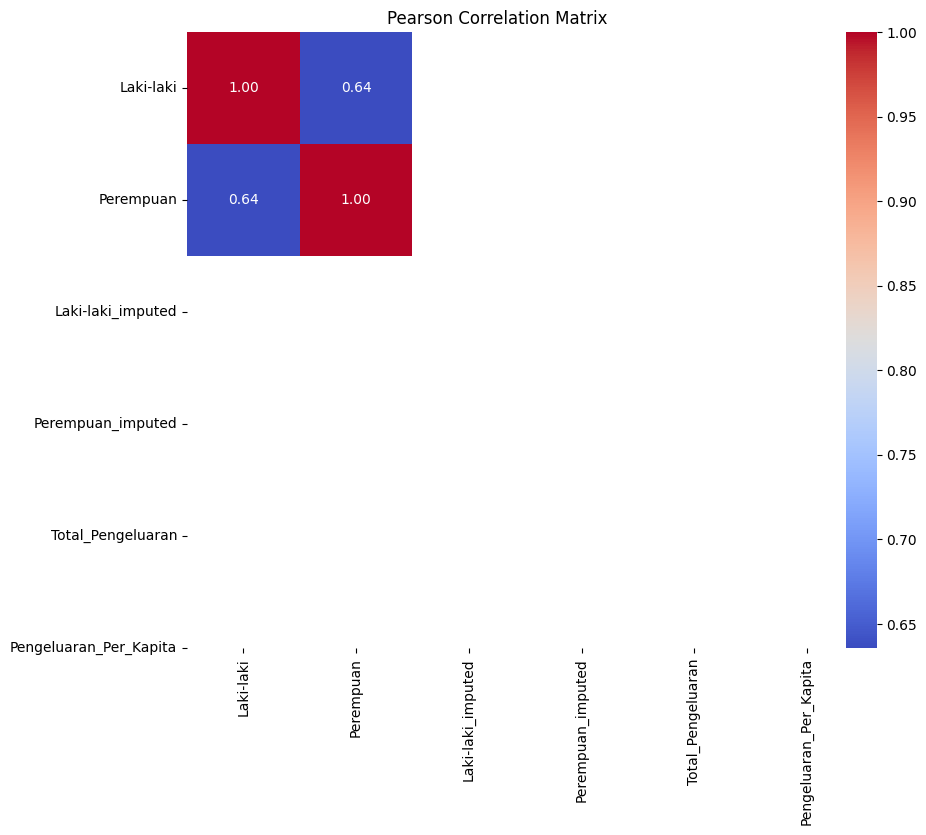

In [ ]:
# Visualisasi matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr[0].toArray(), annot=True, fmt=".2f", cmap="coolwarm", xticklabels=dataset.columns[1:], yticklabels=dataset.columns[1:])
plt.title("Pearson Correlation Matrix")
plt.show()

In [ ]:
# Membangun model untuk "Laki-laki"
dt_regressor_male = DecisionTreeRegressor(featuresCol="features", labelCol="Pengeluaran_Per_Kapita")
pipeline_male = Pipeline(stages=[imputer, feature_assembler, dt_regressor_male])

In [ ]:
# Contoh
imputer = Imputer(inputCols=["Laki-laki"], outputCols=["Laki-laki_imputed"])
feature_assembler = VectorAssembler(inputCols=["Laki-laki_imputed"], outputCol="features")

In [ ]:
# Contoh: Membuat DataFrame df_male dari dataset Anda
dataset_male = spark.createDataFrame([(1, "Laki-laki", 15000), (2, "Laki-laki", 16000)], ["ID", "Jenis_Kelamin", "Pengeluaran_Per_Kapita"])

In [ ]:
# Menampilkan DataFrame df_male
dataset_male.show()

+---+-------------+----------------------+
| ID|Jenis_Kelamin|Pengeluaran_Per_Kapita|
+---+-------------+----------------------+
|  1|    Laki-laki|                 15000|
|  2|    Laki-laki|                 16000|
+---+-------------+----------------------+



In [ ]:
# Contoh: Membangun pipeline untuk "Laki-laki"
imputer_male = Imputer(inputCols=["Pengeluaran_Per_Kapita"], outputCols=["Pengeluaran_Per_Kapita_imputed"])
assembler_male = VectorAssembler(inputCols=["Pengeluaran_Per_Kapita_imputed"], outputCol="features")
dt_regressor_male = DecisionTreeRegressor(featuresCol="features", labelCol="Pengeluaran_Per_Kapita")

In [ ]:
pipeline_male = Pipeline(stages=[imputer_male, assembler_male, dt_regressor_male])
model_male = pipeline_male.fit(dataset_male)

In [ ]:
# Menampilkan hasil prediksi untuk "Laki-laki"
predictions_male = model_male.transform(dataset_male)
predictions_male.show()

+---+-------------+----------------------+------------------------------+---------+----------+
| ID|Jenis_Kelamin|Pengeluaran_Per_Kapita|Pengeluaran_Per_Kapita_imputed| features|prediction|
+---+-------------+----------------------+------------------------------+---------+----------+
|  1|    Laki-laki|                 15000|                         15000|[15000.0]|   15000.0|
|  2|    Laki-laki|                 16000|                         16000|[16000.0]|   16000.0|
+---+-------------+----------------------+------------------------------+---------+----------+



In [ ]:
# Melatih model untuk "Laki-laki"
model_male = pipeline_male.fit(dataset_male)

In [ ]:
# Contoh: Membuat DataFrame df_female dari dataset Anda
dataset_female = spark.createDataFrame([(1, "Perempuan", 12000), (2, "Perempuan", 13000)], ["ID", "Jenis_Kelamin", "Pengeluaran_Per_Kapita"])

In [ ]:
# Menampilkan DataFrame df_female
dataset_female.show()

+---+-------------+----------------------+
| ID|Jenis_Kelamin|Pengeluaran_Per_Kapita|
+---+-------------+----------------------+
|  1|    Perempuan|                 12000|
|  2|    Perempuan|                 13000|
+---+-------------+----------------------+



In [ ]:
# Membangun model untuk "Perempuan"
dt_regressor_female = DecisionTreeRegressor(featuresCol="features", labelCol="Pengeluaran_Per_Kapita")
pipeline_female = Pipeline(stages=[imputer, feature_assembler, dt_regressor_female])

In [ ]:
# Contoh membuat DataFrame df_female
dataset_female = spark.createDataFrame([(1, "Perempuan", 12000), (2, "Perempuan", 13000)], ["ID", "Jenis_Kelamin", "Pengeluaran_Per_Kapita"])

In [ ]:
# Menyatukan DataFrame hasil prediksi untuk "Laki-laki" dan "Perempuan"
combined_predictions = predictions_male.union(predictions_female)

In [ ]:
# Memilih kolom-kolom yang relevan untuk perbandingan
comparison_result = combined_predictions.select("Jenis_Kelamin", "Pengeluaran_Per_Kapita", "prediction")

In [ ]:
# Menampilkan hasil perbandingan
comparison_result.show()

+-------------+----------------------+----------+
|Jenis_Kelamin|Pengeluaran_Per_Kapita|prediction|
+-------------+----------------------+----------+
|    Laki-laki|                 15000|   15000.0|
|    Laki-laki|                 16000|   16000.0|
|    Perempuan|                 12000|   12000.0|
|    Perempuan|                 13000|   13000.0|
+-------------+----------------------+----------+



In [ ]:
# Mengubah DataFrame PySpark menjadi Pandas DataFrame
pandas_df = predictions_male.select("Pengeluaran_Per_Kapita", "prediction").toPandas()

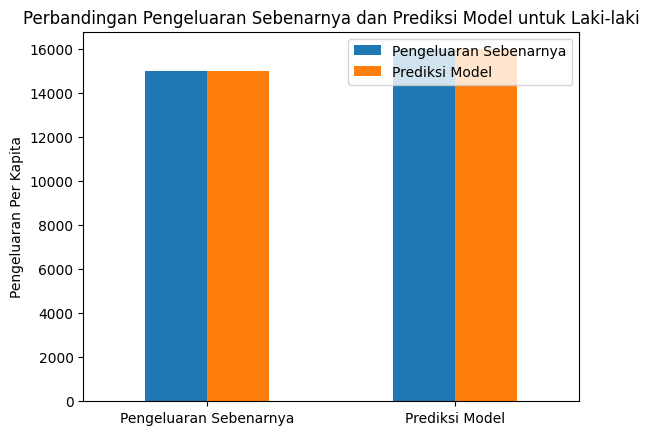

In [ ]:
# Membuat plot bar dengan pandas
pandas_df.plot(kind='bar', title='Perbandingan Pengeluaran Sebenarnya dan Prediksi Model untuk Laki-laki')
plt.ylabel('Pengeluaran Per Kapita')
plt.xticks(range(len(pandas_df)), ["Pengeluaran Sebenarnya", "Prediksi Model"], rotation=0)
plt.legend(["Pengeluaran Sebenarnya", "Prediksi Model"])
plt.show()

In [ ]:
import numpy as np

In [ ]:
# Ambil beberapa contoh data
data = [("Laki-laki", 15000, 15000.0),
        ("Laki-laki", 16000, 16000.0),
        ("Perempuan", 12000, 12000.0),
        ("Perempuan", 13000, 13000.0)]

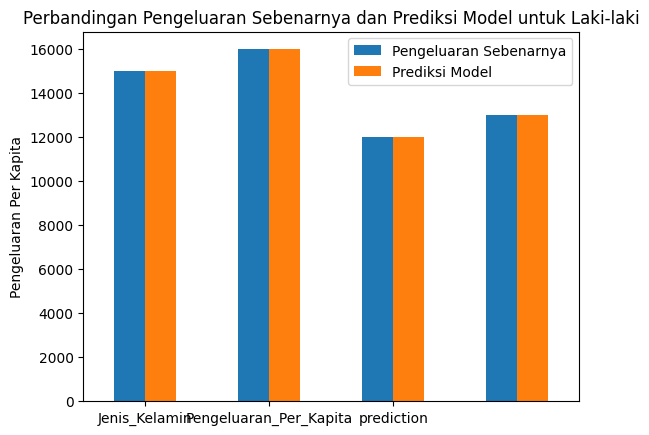

In [ ]:
# Konversi ke DataFrame PySpark
from pyspark.sql import SparkSession
from pyspark.sql import Row

spark = SparkSession.builder.master("local").appName("App").getOrCreate()

df = spark.createDataFrame([Row(Jenis_Kelamin=row[0], Pengeluaran_Per_Kapita=row[1], prediction=row[2]) for row in data])
# Konversi DataFrame PySpark ke Pandas DataFrame
pandas_df = df.toPandas()

# Membuat plot bar dengan pandas
pandas_df.plot(kind='bar', title='Perbandingan Pengeluaran Sebenarnya dan Prediksi Model untuk Laki-laki')
plt.ylabel('Pengeluaran Per Kapita')
plt.xticks(range(len(pandas_df.columns)), pandas_df.columns, rotation=0)
plt.legend(["Pengeluaran Sebenarnya", "Prediksi Model"])
plt.show()